In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
seed = 42

In [3]:
from datasets import load_dataset
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")

In [4]:
train = dataset['train']

In [5]:
train_df = pd.DataFrame(train)

In [6]:
display(train_df.head())
train_df.shape

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


(16407, 3)

In [7]:
labels_to_remove = ['support groups', 'complications', 'stages']
train_df = train_df[~train_df['qtype'].isin(labels_to_remove)]

In [8]:
train_df['qtype'].value_counts()

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
Name: count, dtype: int64

In [9]:
train_df.shape

(16283, 3)

In [10]:
train_df, test_df = train_test_split(train_df ,test_size = 0.3, random_state = seed)

In [54]:
display(test_df.head())
test_df.shape

,qtype,Question,Answer
12083,symptoms,What are the symptoms of Harrod Doman Keele sy...,What are the signs and symptoms of Harrod Doma...
15285,symptoms,What are the symptoms of Preaxial polydactyly ...,What are the signs and symptoms of Preaxial po...
1662,causes,What causes What I need to know about Hirschsp...,"Before birth, a childs nerve cells normally gr..."
11238,symptoms,What are the symptoms of Achondrogenesis ?,What are the signs and symptoms of Achondrogen...
13787,symptoms,What are the symptoms of Trigger thumb ?,What are the signs and symptoms of Trigger thu...


(4885, 3)

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [36]:
# Fit and transform the labels
train_df['labels'] = label_encoder.fit_transform(train_df['qtype'])

In [13]:
# Create a mapping of the original labels to the encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [14]:
# Print the mapping
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [15]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, AdamW

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
labels = train_df['labels'].tolist()

In [18]:
def tokenize_texts_new(texts, batch_size=8):
    input_ids_list = []
    attention_mask_list = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
        
        input_ids_list.append(inputs['input_ids'])
        attention_mask_list.append(inputs['attention_mask'])
    
    # Ensure consistent size for concatenation
    max_length = 512
    
    for i in range(len(input_ids_list)):
        if input_ids_list[i].size(1) != max_length:
            padding_size = max_length - input_ids_list[i].size(1)
            input_ids_list[i] = torch.nn.functional.pad(input_ids_list[i], (0, padding_size), value=tokenizer.pad_token_id)
            attention_mask_list[i] = torch.nn.functional.pad(attention_mask_list[i], (0, padding_size), value=0)
    
    # Concatenate all batches to create single tensors
    input_ids = torch.cat(input_ids_list, dim=0)
    attention_masks = torch.cat(attention_mask_list, dim=0)
    
    return input_ids, attention_masks

In [19]:
# Tokenize the texts in your dataset
texts = train_df['Question'].tolist()
input_ids, attention_masks = tokenize_texts_new(texts)

In [20]:
display(len(input_ids))
display(len(attention_masks))
display(input_ids.shape)
display(attention_masks.shape)

11398

11398

torch.Size([11398, 512])

torch.Size([11398, 512])

In [21]:
# Convert labels to PyTorch tensor
labels = torch.tensor(labels)

In [22]:
labels.shape

torch.Size([11398])

In [23]:
# Split the dataset into train and test sets using train_test_split
input_ids_train, input_ids_test, attention_masks_train, attention_masks_test, labels_train, labels_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.3, random_state=seed)

In [24]:
display(len(input_ids_train))
display(len(attention_masks_train))

7978

7978

In [25]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=13)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [27]:
# Freeze all layers except the last two
for name, param in model.named_parameters():
    if 'classifier' in name or 'bert.encoder.layer.11' in name or 'bert.encoder.layer.10' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [28]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = (len(input_ids_train) // 8) * 3  # Assuming 3 epochs and batch size of 8
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
# Training function
def train(model, input_ids_train, attention_masks_train, labels_train, optimizer, scheduler, device, batch_size=16):
    model.train()
    total_loss = 0
    for i in range(0, len(input_ids_train), batch_size):
        batch_input_ids = input_ids_train[i:i+batch_size].to(device)
        batch_attention_masks = attention_masks_train[i:i+batch_size].to(device)
        batch_labels = labels_train[i:i+batch_size].to(device)
        
        model.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f"Batch {i}, Train loss: {loss.item():.4f}")
    return total_loss / (len(input_ids_train) // batch_size)

In [30]:
# Main training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [31]:
epochs = 3
for epoch in range(epochs):
    print('\n\nTraining Epoch', epoch)
    train_loss = train(model, input_ids_train, attention_masks_train, labels_train, optimizer, scheduler, device)
    print(f"Epoch {epoch + 1}, Train loss: {train_loss:.4f}")



Training Epoch 0
Batch 0, Train loss: 2.4349
Batch 16, Train loss: 2.3970
Batch 32, Train loss: 2.3868
Batch 48, Train loss: 2.4485
Batch 64, Train loss: 2.5389
Batch 80, Train loss: 2.4278
Batch 96, Train loss: 2.2580
Batch 112, Train loss: 2.2143
Batch 128, Train loss: 2.4280
Batch 144, Train loss: 2.4625
Batch 160, Train loss: 2.1052
Batch 176, Train loss: 2.2631
Batch 192, Train loss: 2.3068
Batch 208, Train loss: 2.2464
Batch 224, Train loss: 2.3579
Batch 240, Train loss: 2.2143
Batch 256, Train loss: 2.2499
Batch 272, Train loss: 2.1053
Batch 288, Train loss: 2.2097
Batch 304, Train loss: 2.1536
Batch 320, Train loss: 1.8191
Batch 336, Train loss: 2.1382
Batch 352, Train loss: 2.1615
Batch 368, Train loss: 2.4644
Batch 384, Train loss: 1.9853
Batch 400, Train loss: 2.0758
Batch 416, Train loss: 1.9267
Batch 432, Train loss: 1.8766
Batch 448, Train loss: 1.9269
Batch 464, Train loss: 2.1904
Batch 480, Train loss: 2.1789
Batch 496, Train loss: 2.4177
Batch 512, Train loss: 1.8769

Batch 4256, Train loss: 0.4188
Batch 4272, Train loss: 0.4845
Batch 4288, Train loss: 0.6199
Batch 4304, Train loss: 0.4169
Batch 4320, Train loss: 0.4864
Batch 4336, Train loss: 0.5069
Batch 4352, Train loss: 0.7359
Batch 4368, Train loss: 0.4027
Batch 4384, Train loss: 0.3444
Batch 4400, Train loss: 0.5066
Batch 4416, Train loss: 0.3461
Batch 4432, Train loss: 0.5628
Batch 4448, Train loss: 0.3341
Batch 4464, Train loss: 0.3785
Batch 4480, Train loss: 0.3178
Batch 4496, Train loss: 0.4060
Batch 4512, Train loss: 0.4290
Batch 4528, Train loss: 0.4519
Batch 4544, Train loss: 0.4246
Batch 4560, Train loss: 0.2664
Batch 4576, Train loss: 0.4161
Batch 4592, Train loss: 0.4216
Batch 4608, Train loss: 0.4399
Batch 4624, Train loss: 0.3213
Batch 4640, Train loss: 0.4634
Batch 4656, Train loss: 0.4727
Batch 4672, Train loss: 0.4301
Batch 4688, Train loss: 0.3980
Batch 4704, Train loss: 0.4122
Batch 4720, Train loss: 0.3744
Batch 4736, Train loss: 0.3512
Batch 4752, Train loss: 0.4643
Batch 47

Batch 512, Train loss: 0.1389
Batch 528, Train loss: 0.1354
Batch 544, Train loss: 0.1159
Batch 560, Train loss: 0.1373
Batch 576, Train loss: 0.1137
Batch 592, Train loss: 0.1879
Batch 608, Train loss: 0.1591
Batch 624, Train loss: 0.2214
Batch 640, Train loss: 0.1174
Batch 656, Train loss: 0.1193
Batch 672, Train loss: 0.1817
Batch 688, Train loss: 0.2204
Batch 704, Train loss: 0.2200
Batch 720, Train loss: 0.1316
Batch 736, Train loss: 0.1707
Batch 752, Train loss: 0.3043
Batch 768, Train loss: 0.2627
Batch 784, Train loss: 0.1459
Batch 800, Train loss: 0.1774
Batch 816, Train loss: 0.2370
Batch 832, Train loss: 0.1359
Batch 848, Train loss: 0.1745
Batch 864, Train loss: 0.2003
Batch 880, Train loss: 0.1513
Batch 896, Train loss: 0.1217
Batch 912, Train loss: 0.1650
Batch 928, Train loss: 0.1662
Batch 944, Train loss: 0.2004
Batch 960, Train loss: 0.1940
Batch 976, Train loss: 0.1201
Batch 992, Train loss: 0.2479
Batch 1008, Train loss: 0.1659
Batch 1024, Train loss: 0.1626
Batch 10

Batch 4768, Train loss: 0.1422
Batch 4784, Train loss: 0.3419
Batch 4800, Train loss: 0.1313
Batch 4816, Train loss: 0.1097
Batch 4832, Train loss: 0.1660
Batch 4848, Train loss: 0.0915
Batch 4864, Train loss: 0.0924
Batch 4880, Train loss: 0.1043
Batch 4896, Train loss: 0.1557
Batch 4912, Train loss: 0.1100
Batch 4928, Train loss: 0.1337
Batch 4944, Train loss: 0.1257
Batch 4960, Train loss: 0.0868
Batch 4976, Train loss: 0.1122
Batch 4992, Train loss: 0.1179
Batch 5008, Train loss: 0.0781
Batch 5024, Train loss: 0.1305
Batch 5040, Train loss: 0.1176
Batch 5056, Train loss: 0.0948
Batch 5072, Train loss: 0.0932
Batch 5088, Train loss: 0.0717
Batch 5104, Train loss: 0.0853
Batch 5120, Train loss: 0.1531
Batch 5136, Train loss: 0.0745
Batch 5152, Train loss: 0.0712
Batch 5168, Train loss: 0.1147
Batch 5184, Train loss: 0.1334
Batch 5200, Train loss: 0.0915
Batch 5216, Train loss: 0.0825
Batch 5232, Train loss: 0.1266
Batch 5248, Train loss: 0.1340
Batch 5264, Train loss: 0.0791
Batch 52

Batch 1040, Train loss: 0.0811
Batch 1056, Train loss: 0.0980
Batch 1072, Train loss: 0.0705
Batch 1088, Train loss: 0.0929
Batch 1104, Train loss: 0.0811
Batch 1120, Train loss: 0.0813
Batch 1136, Train loss: 0.0848
Batch 1152, Train loss: 0.0843
Batch 1168, Train loss: 0.0627
Batch 1184, Train loss: 0.0481
Batch 1200, Train loss: 0.0642
Batch 1216, Train loss: 0.0984
Batch 1232, Train loss: 0.1706
Batch 1248, Train loss: 0.0607
Batch 1264, Train loss: 0.0495
Batch 1280, Train loss: 0.0728
Batch 1296, Train loss: 0.0882
Batch 1312, Train loss: 0.0867
Batch 1328, Train loss: 0.0666
Batch 1344, Train loss: 0.1037
Batch 1360, Train loss: 0.0877
Batch 1376, Train loss: 0.1001
Batch 1392, Train loss: 0.0747
Batch 1408, Train loss: 0.0658
Batch 1424, Train loss: 0.0795
Batch 1440, Train loss: 0.0626
Batch 1456, Train loss: 0.1284
Batch 1472, Train loss: 0.0674
Batch 1488, Train loss: 0.0830
Batch 1504, Train loss: 0.0638
Batch 1520, Train loss: 0.0784
Batch 1536, Train loss: 0.1301
Batch 15

Batch 5280, Train loss: 0.0570
Batch 5296, Train loss: 0.0302
Batch 5312, Train loss: 0.0475
Batch 5328, Train loss: 0.0613
Batch 5344, Train loss: 0.0504
Batch 5360, Train loss: 0.0399
Batch 5376, Train loss: 0.0581
Batch 5392, Train loss: 0.0568
Batch 5408, Train loss: 0.0510
Batch 5424, Train loss: 0.0423
Batch 5440, Train loss: 0.0579
Batch 5456, Train loss: 0.0708
Batch 5472, Train loss: 0.0459
Batch 5488, Train loss: 0.0487
Batch 5504, Train loss: 0.0788
Batch 5520, Train loss: 0.0390
Batch 5536, Train loss: 0.0645
Batch 5552, Train loss: 0.0631
Batch 5568, Train loss: 0.0534
Batch 5584, Train loss: 0.0693
Batch 5600, Train loss: 0.0368
Batch 5616, Train loss: 0.0608
Batch 5632, Train loss: 0.0702
Batch 5648, Train loss: 0.0582
Batch 5664, Train loss: 0.0528
Batch 5680, Train loss: 0.0504
Batch 5696, Train loss: 0.0669
Batch 5712, Train loss: 0.0454
Batch 5728, Train loss: 0.0934
Batch 5744, Train loss: 0.0582
Batch 5760, Train loss: 0.0583
Batch 5776, Train loss: 0.0845
Batch 57

In [32]:
# Evaluation function
def evaluate(model, input_ids_test, attention_masks_test, labels_test, device, batch_size=8):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for i in range(0, len(input_ids_test), batch_size):
            batch_input_ids = input_ids_test[i:i+batch_size].to(device)
            batch_attention_masks = attention_masks_test[i:i+batch_size].to(device)
            batch_labels = labels_test[i:i+batch_size].to(device)
            
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
            logits = outputs.logits
            preds.append(logits.argmax(dim=1).cpu().numpy())
            true_labels.append(batch_labels.cpu().numpy())
    preds = np.concatenate(preds)
    true_labels = np.concatenate(true_labels)
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    precision = precision_score(true_labels, preds, average='weighted')
    recall = recall_score(true_labels, preds, average='weighted')
    return accuracy, f1, precision, recall, preds

In [33]:
# Evaluate the model
accuracy, f1, precision, recall, preds = evaluate(model, input_ids_test, attention_masks_test, labels_test, device)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9985
F1 Score: 0.9985
Precision: 0.9986
Recall: 0.9985


In [39]:
display(preds)
preds.shape

array([ 5,  2, 11, ..., 11, 12,  4], dtype=int64)

(3420,)

In [41]:
preds_tensor = torch.tensor(preds)

In [42]:
preds_tensor.shape

torch.Size([3420])

In [40]:
labels.shape

torch.Size([11398])

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 3000x3000 with 0 Axes>

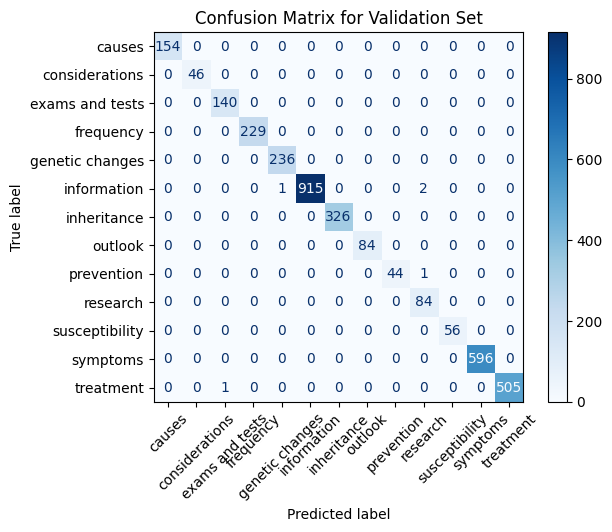

In [52]:
# Calculate the confusion matrix
cm = confusion_matrix(labels_test, preds)

# Create a larger figure for better readability
plt.figure(figsize=(30,30))

# Display the confusion matrix with tilted x-tick labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.title('Confusion Matrix for Validation Set')
plt.show()

In [55]:
# Encode labels for the test set
test_df['labels'] = label_encoder.transform(test_df['qtype'])

In [56]:
# Tokenize the texts in the test set
test_texts = test_df['Question'].tolist()
test_input_ids, test_attention_masks = tokenize_texts_new(test_texts)

In [57]:
test_labels = torch.tensor(test_df['labels'].tolist())

In [59]:
# Evaluate on the test set
print("Evaluating on the test set...")
test_accuracy, test_f1, test_precision, test_recall, test_preds = evaluate(
    model, test_input_ids, test_attention_masks, test_labels, device)

Evaluating on the test set...


In [60]:
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.9996
Test F1 Score: 0.9996
Test Precision: 0.9996
Test Recall: 0.9996


<Figure size 3000x3000 with 0 Axes>

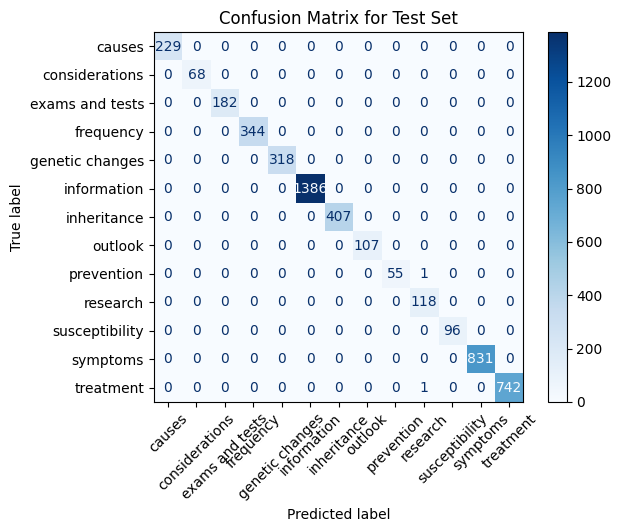

In [61]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Create a larger figure for better readability
plt.figure(figsize=(30,30))

# Display the confusion matrix with tilted x-tick labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.title('Confusion Matrix for Test Set')
plt.show()